In [ ]:
import numpy as np
import pandas as pd
from skimage.draw import ellipse_perimeter, circle_perimeter

def extract_circular_points(regions):
    circular_points = []

    for region in regions:
        # Check circularity of the region
        circularity = region.perimeter ** 2 / (4 * np.pi * region.area)

        # Define a circularity threshold (adjust as needed)
        circularity_threshold = 0.8

        if circularity > circularity_threshold:
            # Get the centroid coordinates
            centroid_row, centroid_col = region.centroid

            # Generate more results for the circular point
            additional_results = generate_additional_results(centroid_row, centroid_col)

            # Append the circular point and additional results to the list
            circular_points.append({
                'centroid_row': centroid_row,
                'centroid_col': centroid_col,
                'additional_results': additional_results
            })

    return circular_points

def generate_additional_results(row, col):
    # Generate additional results for the circular point, e.g., extract pixel values or statistics
    additional_results = {}

    # Example: Get the pixel values along the circular perimeter
    min_radius = 1
    max_radius = 15

    # Generate circular and elliptical perimeters
    perimeters = []
    for radius in range(min_radius, max_radius+1):
        circle_perimeter_row, circle_perimeter_col = circle_perimeter(int(row), int(col), radius=radius)
        ellipse_perimeter_row, ellipse_perimeter_col = ellipse_perimeter(int(row), int(col), radius, int(radius*1.5))
        perimeters.append((circle_perimeter_row, circle_perimeter_col))
        perimeters.append((ellipse_perimeter_row, ellipse_perimeter_col))

    # Extract pixel values for each perimeter
    pixel_values = []
    for perimeter_row, perimeter_col in perimeters:
        pixel_values.append((perimeter_row, perimeter_col))

    additional_results['perimeter_pixel_values'] = pixel_values

    return additional_results

In [ ]:
import numpy as np
from skimage import io, color, filters, measure
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt
from skimage import exposure
# from extract_circular_points import extract_circular_points

# Function to perform image segmentation
def perform_segmentation(image_path):
    # Load the image and convert it to grayscale
    img = io.imread(image_path)
    img_gray = color.rgb2gray(img)

    # Apply histogram equalization to enhance contrast
    img_gray = exposure.equalize_hist(img_gray)

    # Compute the distance transform
    distance = ndi.distance_transform_edt(img_gray)

    # Calculate the threshold using Otsu's method
    threshold = filters.threshold_otsu(img_gray)

    # Find peaks in the distance map
    markers = peak_local_max(distance, min_distance=10, labels=img_gray > threshold)

    # Resize markers to the same shape as the mask
    markers = np.resize(markers, img_gray.shape)

    # Perform watershed segmentation
    labeled_image = watershed(-distance, markers, mask=img_gray)

    return labeled_image

# Function to extract features from segmented regions
def extract_features_from_segmentation(labeled_image, img_gray, label, filepath):
    # Calculate the features from each segmented region
    regions = measure.regionprops(labeled_image, intensity_image=img_gray)

    # circular_points = extract_circular_points(regions)

    # # Create subplots for displaying images side by side
    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # # Display the grayscale image without the red color
    # axs[0].imshow(img_gray, cmap='gray')
    # axs[0].set_title('Grayscale Image')

    # # Display the original image with circular points
    # axs[1].imshow(img_gray)
    # axs[1].set_title('Original Image')

    # # Plot the circular points and perimeters
    # for circular_point in circular_points:
    #     centroid_row = circular_point['centroid_row']
    #     centroid_col = circular_point['centroid_col']
    #     additional_results = circular_point['additional_results']

    #     # Plot the centroid point as a dot
    #     axs[1].plot(centroid_col, centroid_row, 'ro', markersize=5)

    #     # Plot the circular and elliptical perimeters
    #     for perimeter_row, perimeter_col in additional_results['perimeter_pixel_values']:
    #         axs[1].plot(perimeter_col, perimeter_row, 'r-', linewidth=1)

    # # Adjust spacing between subplots
    # plt.tight_layout()

    # # Show the plot
    # plt.show()

    # # Access the circular points and additional results
    # for circular_point in circular_points:
    #     centroid_row = circular_point['centroid_row']
    #     centroid_col = circular_point['centroid_col']
    #     # additional_results = circular_point['additional_results']
    #     # print(f"Circular Point: Row={centroid_row}, Col={centroid_col}")

    features = []
    concave_points_values = []
    symmetry_values = []
    fractal_dimension_values = []

    count = 0
    for i, region in enumerate(regions):
        # print("region", region, region.perimeter, region.area, region.convex_area, region.convex_image)
        if region.area == 0 or region.perimeter == 0:
            continue
        radius = region.perimeter / (2.0 * np.pi)
        texture = np.std(img_gray[region.slice])
        perimeter = region.perimeter
        area = region.area
        smoothness = (perimeter ** 2) / area
        compactness = (perimeter ** 2) / area
        concavity = region.convex_area - area
        concave_points = len(region.convex_image) - np.sum(region.convex_image)
        IMG_SIZE = max(img_gray.shape)
        symmetry = np.sum(np.abs(img_gray[region.slice] - np.flipud(img_gray[region.slice]))) / (IMG_SIZE ** 2)
        fractal_dimension = np.log(4 * np.pi * area) / (2 * np.log(perimeter))

        if concave_points != 0:
            concave_points_values.append(concave_points)
        if concave_points == 0:
            concave_points = np.mean(concave_points_values)

        if symmetry != 0:
            symmetry_values.append(symmetry)
        if symmetry == 0:
            symmetry = np.mean(symmetry_values)

        if fractal_dimension != 0:
            fractal_dimension_values.append(fractal_dimension)
        if fractal_dimension == 0:
            fractal_dimension = np.mean(fractal_dimension_values)

        count = count+1
        feature = {
            'radius': radius,
            'texture': texture,
            'perimeter': perimeter,
            'area': area,
            'smoothness': smoothness,
            'compactness': compactness,
            'concavity': concavity,
            'concave_points': concave_points,
            'symmetry': symmetry,
            'fractal_dimension': fractal_dimension,
            'label': label,
            'path': filepath,
            'path_id': count
        }
        print("feature", feature)
        # if(i==0):
        #     print("labeled_image", labeled_image, label, feature)
        #     plt.imshow(labeled_image)
        #     plt.axis('off')  # Turn off the axis labels
        #     plt.show()
        features.append(feature)
    return features



In [ ]:
import numpy as np
import sys
import os
from skimage import io, color, filters, measure
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt

def perform_segmentation(image_path):

    # Load the image and convert it to grayscale
    img = io.imread(image_path)
    img_gray = img
    # Only convert image to grayscale if RGB
    if img.shape[-1] == 3:
        img_gray = color.rgb2gray(img)

    # Compute the distance transform
    distance = ndi.distance_transform_edt(img_gray)

    # Calculate the threshold using Otsu's method
    threshold = filters.threshold_otsu(img_gray)

    # Find peaks in the distance map
    markers = peak_local_max(distance, min_distance=10, labels=img_gray > threshold)

    # Resize markers to the same shape as the mask
    markers = np.resize(markers, img_gray.shape)

    # Perform watershed segmentation
    labeled_image = watershed(-distance, markers, mask=img_gray)

    return labeled_image

# Function to extract features from segmented regions
def extract_features_from_segmentation(labeled_image, img_gray, label, filepath):
    # Calculate the features from each segmented region
    regions = measure.regionprops(labeled_image, intensity_image=img_gray)

    circular_points = extract_circular_points(regions)

    features = []
    for i, region in enumerate(regions):
        # print("region", region, region.perimeter, region.area, region.convex_area, region.convex_image)
        if region.area == 0 or region.perimeter == 0:
            continue
        radius = region.perimeter / (2.0 * np.pi)
        texture = np.std(img_gray[region.slice])
        perimeter = region.perimeter
        area = region.area
        smoothness = (perimeter ** 2) / area
        compactness = (perimeter ** 2) / area
        concavity = region.convex_area - area
        concave_points = len(region.convex_image) - np.sum(region.convex_image)
        IMG_SIZE = max(img_gray.shape)
        symmetry = np.sum(np.abs(img_gray[region.slice] - np.flipud(img_gray[region.slice]))) / (IMG_SIZE ** 2)
        fractal_dimension = np.log(4 * np.pi * area) / (2 * np.log(perimeter))

        feature = {
            'index': i,
            'radius': radius,
            'texture': texture,
            'perimeter': perimeter,
            'area': area,
            'smoothness': smoothness,
            'compactness': compactness,
            'concavity': concavity,
            'concave_points': concave_points,
            'symmetry': symmetry,
            'fractal_dimension': fractal_dimension,
            'label': label,
            'path': filepath
        }
        print("feature", feature)
        if(i==0):
            print("labeled_image", labeled_image, label, feature)
            plt.imshow(labeled_image)
            plt.axis('off')  # Turn off the axis labels
            plt.show()
        features.append(feature)
    return features

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
feature {'index': 0, 'radius': 1075.4099504719368, 'texture': 42.89638017253203, 'perimeter': 6757.0, 'area': 6789, 'smoothness': 6725.150832228605, 'compactness': 6725.150832228605, 'concavity': 97817, 'concave_points': -104094, 'symmetry': 51.146484375, 'fractal_dimension': 0.6437770907850706, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/600749.png'}
labeled_image [[  0   0   0 ...   0   0   0]
 [254  10 354 ...   0   0   0]
 [254  10 354 ...   0   0   0]
 ...
 [254  10 354 ...   0   0   0]
 [254  10 354 ...   0   0   0]
 [254  10 354 ...   0   0   0]] 0 {'index': 0, 'radius': 1075.4099504719368, 'texture': 42.89638017253203, 'perimeter': 6757.0, 'area': 6789, 'smoothness': 6725.150832228605, 'compactness': 6725.150832228605, 'concavity': 97817, 'concave_points': -10409

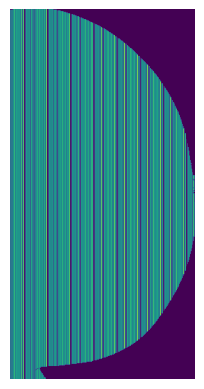

feature {'index': 1, 'radius': 524.8930023170708, 'texture': 42.57796341323027, 'perimeter': 3298.0, 'area': 3314, 'smoothness': 3282.077248038624, 'compactness': 3282.077248038624, 'concavity': 92185, 'concave_points': -94987, 'symmetry': 47.01171875, 'fractal_dimension': 0.6565141068597994, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/600749.png'}
feature {'index': 2, 'radius': 1000.7662821618379, 'texture': 45.025966448575076, 'perimeter': 6288.0, 'area': 6323, 'smoothness': 6253.193737150087, 'compactness': 6253.193737150087, 'concavity': 89967, 'concave_points': -95778, 'symmetry': 47.3935546875, 'fractal_dimension': 0.6450068287552588, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/600749.png'}
feature {'index': 3, 'radius': 515.3437057315571, 'texture': 43.235156202116286, 'perimeter': 3238.0, 'area': 3254

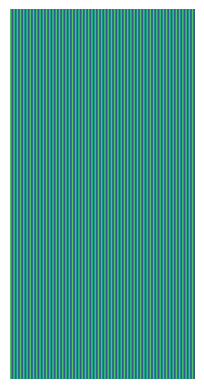

feature {'index': 1, 'radius': 10389.634685038927, 'texture': 66.43697940570863, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'compactness': 65025.0, 'concavity': 65024, 'concave_points': -130048, 'symmetry': 53.6748046875, 'fractal_dimension': 0.6143260559750294, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/1800748.png'}
feature_array [{'index': 0, 'radius': 10389.634685038927, 'texture': 66.69134911505358, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'compactness': 65025.0, 'concavity': 65024, 'concave_points': -130048, 'symmetry': 53.478515625, 'fractal_dimension': 0.6143260559750294, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/1800748.png'}, {'index': 1, 'radius': 10389.634685038927, 'texture': 66.43697940570863, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'com

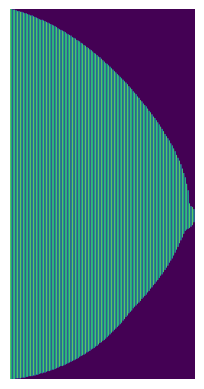

feature {'index': 1, 'radius': 7105.63158928076, 'texture': 58.820663906693284, 'perimeter': 44646.0, 'area': 44902, 'smoothness': 44391.45953409647, 'compactness': 44391.45953409647, 'concavity': 45037, 'concave_points': -89427, 'symmetry': 44.677734375, 'fractal_dimension': 0.6184671521330793, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/896533.png'}
feature_array [{'index': 0, 'radius': 7063.773839247591, 'texture': 58.97251833969997, 'perimeter': 44383.0, 'area': 44639, 'smoothness': 44128.468133246715, 'compactness': 44128.468133246715, 'concavity': 44785, 'concave_points': -88912, 'symmetry': 44.4482421875, 'fractal_dimension': 0.6185341408219958, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/896533.png'}, {'index': 1, 'radius': 7105.63158928076, 'texture': 58.820663906693284, 'perimeter': 44646.0, 'area':

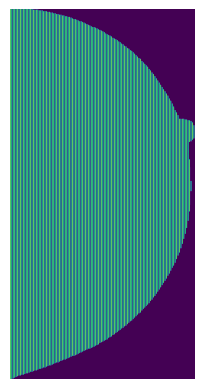

feature {'index': 1, 'radius': 7896.790811390571, 'texture': 64.84024878268538, 'perimeter': 49617.0, 'area': 49877, 'smoothness': 49358.35533412194, 'compactness': 49358.35533412194, 'concavity': 50455, 'concave_points': -99820, 'symmetry': 48.5283203125, 'fractal_dimension': 0.6172877300840273, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/1315983.png'}
feature_array [{'index': 0, 'radius': 7857.638695389965, 'texture': 65.1874008028047, 'perimeter': 49371.0, 'area': 49633, 'smoothness': 49110.38303145085, 'compactness': 49110.38303145085, 'concavity': 50239, 'concave_points': -99360, 'symmetry': 48.30859375, 'fractal_dimension': 0.6173447380073758, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/1315983.png'}, {'index': 1, 'radius': 7896.790811390571, 'texture': 64.84024878268538, 'perimeter': 49617.0, 'area': 4

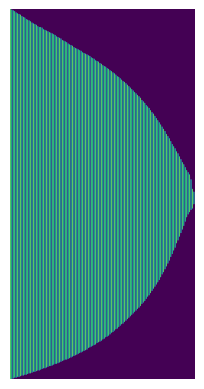

feature {'index': 1, 'radius': 6987.220311620389, 'texture': 76.21276989757214, 'perimeter': 43902.0, 'area': 44158, 'smoothness': 43647.48412518683, 'compactness': 43647.48412518683, 'concavity': 44240, 'concave_points': -87886, 'symmetry': 43.7685546875, 'fractal_dimension': 0.618657908273496, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/392070.png'}
feature_array [{'index': 0, 'radius': 6946.15833630268, 'texture': 76.41908332959618, 'perimeter': 43644.0, 'area': 43900, 'smoothness': 43389.49284738041, 'compactness': 43389.49284738041, 'concavity': 43975, 'concave_points': -87363, 'symmetry': 43.5380859375, 'fractal_dimension': 0.618724973431942, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/392070.png'}, {'index': 1, 'radius': 6987.220311620389, 'texture': 76.21276989757214, 'perimeter': 43902.0, 'area': 441

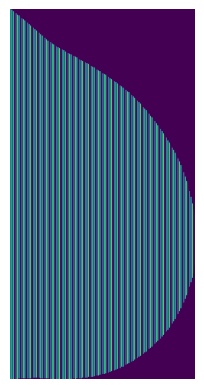

feature {'index': 1, 'radius': 3854.6404611912462, 'texture': 38.511920747429, 'perimeter': 24219.42031021678, 'area': 24223, 'smoothness': 24215.841149442313, 'compactness': 24215.841149442313, 'concavity': 71607, 'concave_points': -95323, 'symmetry': 54.41015625, 'fractal_dimension': 0.6253687263097152, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/1766685.png'}
feature {'index': 2, 'radius': 1949.488897932626, 'texture': 38.21999150145467, 'perimeter': 12249.0, 'area': 12313, 'smoothness': 12185.332656541867, 'compactness': 12185.332656541867, 'concavity': 84651, 'concave_points': -96454, 'symmetry': 55.2431640625, 'fractal_dimension': 0.6347169758392499, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/1766685.png'}
feature {'index': 3, 'radius': 1930.7086146477825, 'texture': 38.42132796485508, 'perimeter': 121

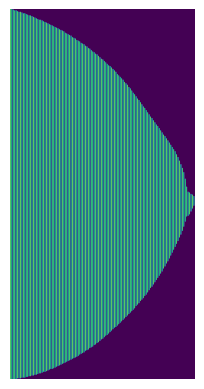

feature {'index': 1, 'radius': 7029.714681425925, 'texture': 80.0646882998254, 'perimeter': 44169.0, 'area': 44425, 'smoothness': 43914.47520540236, 'compactness': 43914.47520540236, 'concavity': 44517, 'concave_points': -88430, 'symmetry': 43.9130859375, 'fractal_dimension': 0.6185890042445482, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/4523575.png'}
feature_array [{'index': 0, 'radius': 6988.9710159944, 'texture': 80.21388270808612, 'perimeter': 43913.0, 'area': 44169, 'smoothness': 43658.48375557518, 'compactness': 43658.48375557518, 'concavity': 44288, 'concave_points': -87945, 'symmetry': 43.6767578125, 'fractal_dimension': 0.6186550595199015, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/4523575.png'}, {'index': 1, 'radius': 7029.714681425925, 'texture': 80.0646882998254, 'perimeter': 44169.0, 'area': 44

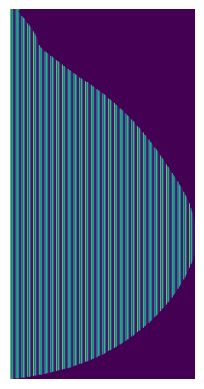

feature {'index': 1, 'radius': 1695.477608757961, 'texture': 44.48001907512267, 'perimeter': 10653.0, 'area': 10719, 'smoothness': 10587.406381192275, 'compactness': 10587.406381192275, 'concavity': 74785, 'concave_points': -84993, 'symmetry': 49.75, 'fractal_dimension': 0.636797006644548, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/7667615.png'}
feature {'index': 2, 'radius': 1684.3367627415284, 'texture': 44.4170235821527, 'perimeter': 10583.0, 'area': 10647, 'smoothness': 10519.384709307786, 'compactness': 10519.384709307786, 'concavity': 73875, 'concave_points': -84011, 'symmetry': 49.5576171875, 'fractal_dimension': 0.6368863879420078, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/7667615.png'}
feature {'index': 3, 'radius': 1705.9818350020262, 'texture': 44.55693189421735, 'perimeter': 10719.0, 'area': 10

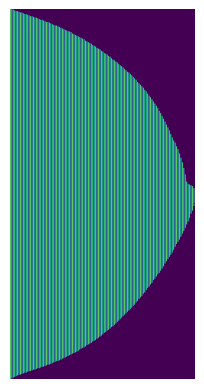

feature {'index': 1, 'radius': 7147.807649200112, 'texture': 42.77388556518755, 'perimeter': 44911.0, 'area': 45169, 'smoothness': 44654.47366556709, 'compactness': 44654.47366556709, 'concavity': 45308, 'concave_points': -89965, 'symmetry': 43.890625, 'fractal_dimension': 0.6184022020234021, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/3754064.png'}
feature_array [{'index': 0, 'radius': 7108.496378256414, 'texture': 42.66344589713581, 'perimeter': 44664.0, 'area': 44922, 'smoothness': 44407.48176839856, 'compactness': 44407.48176839856, 'concavity': 45090, 'concave_points': -89500, 'symmetry': 43.6591796875, 'fractal_dimension': 0.6184646639761632, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/3754064.png'}, {'index': 1, 'radius': 7147.807649200112, 'texture': 42.77388556518755, 'perimeter': 44911.0, 'area': 45

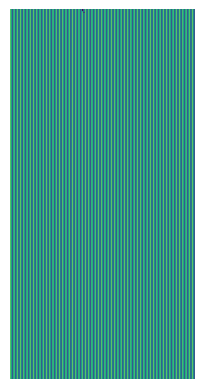

feature {'index': 1, 'radius': 10388.679755380377, 'texture': 90.32856319057943, 'perimeter': 65274.0, 'area': 65532, 'smoothness': 65017.015748031496, 'compactness': 65017.015748031496, 'concavity': 65028, 'concave_points': -130048, 'symmetry': 60.98046875, 'fractal_dimension': 0.614328396500053, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/5703298.png'}
feature_array [{'index': 0, 'radius': 10388.838910323468, 'texture': 90.7926264179371, 'perimeter': 65275.0, 'area': 65531, 'smoothness': 65020.000076299766, 'compactness': 65020.000076299766, 'concavity': 65029, 'concave_points': -130048, 'symmetry': 60.9462890625, 'fractal_dimension': 0.6143268593523814, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/5703298.png'}, {'index': 1, 'radius': 10388.679755380377, 'texture': 90.32856319057943, 'perimeter': 65274.0, '

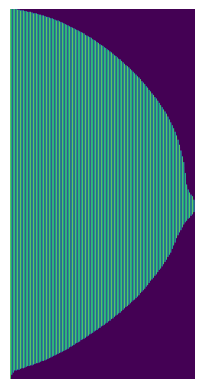

feature {'index': 1, 'radius': 7128.390746142901, 'texture': 41.00813187808461, 'perimeter': 44789.0, 'area': 45045, 'smoothness': 44534.4549006549, 'compactness': 44534.4549006549, 'concavity': 45479, 'concave_points': -90012, 'symmetry': 45.611328125, 'fractal_dimension': 0.6184309287341893, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/3030328.png'}
feature_array [{'index': 0, 'radius': 7089.71609497157, 'texture': 40.78598452372958, 'perimeter': 44546.0, 'area': 44802, 'smoothness': 44291.46279183965, 'compactness': 44291.46279183965, 'concavity': 45211, 'concave_points': -89504, 'symmetry': 44.912109375, 'fractal_dimension': 0.6184925667072495, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/3030328.png'}, {'index': 1, 'radius': 7128.390746142901, 'texture': 41.00813187808461, 'perimeter': 44789.0, 'area': 450

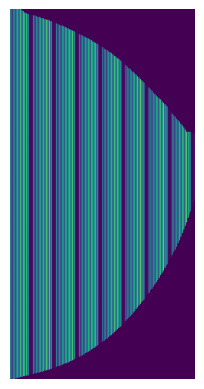

feature {'index': 1, 'radius': 1447.0367425915124, 'texture': 58.95391024203026, 'perimeter': 9092.0, 'area': 9140, 'smoothness': 9044.252078774616, 'compactness': 9044.252078774616, 'concavity': 83347, 'concave_points': -91975, 'symmetry': 45.5771484375, 'fractal_dimension': 0.6391249554300528, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/8076716.png'}
feature {'index': 2, 'radius': 445.1563758280313, 'texture': 60.12431039315681, 'perimeter': 2797.0, 'area': 2813, 'smoothness': 2781.0910060433703, 'compactness': 2781.0910060433703, 'concavity': 77934, 'concave_points': -80249, 'symmetry': 40.1640625, 'fractal_dimension': 0.6598180198211244, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/8076716.png'}
feature {'index': 3, 'radius': 439.10848799053923, 'texture': 60.305920151972835, 'perimeter': 2759.0, 'area': 2

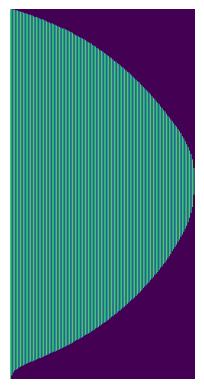

feature {'index': 1, 'radius': 7065.842853507786, 'texture': 54.96989971441214, 'perimeter': 44396.0, 'area': 44652, 'smoothness': 44141.46770581385, 'compactness': 44141.46770581385, 'concavity': 44986, 'concave_points': -89126, 'symmetry': 43.783203125, 'fractal_dimension': 0.6185308183182133, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/6764252.png'}
feature_array [{'index': 0, 'radius': 7024.780878190077, 'texture': 55.023101725948884, 'perimeter': 44138.0, 'area': 44394, 'smoothness': 43883.47623552733, 'compactness': 43883.47623552733, 'concavity': 44671, 'concave_points': -88555, 'symmetry': 43.13671875, 'fractal_dimension': 0.6185969784287, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/6764252.png'}, {'index': 1, 'radius': 7065.842853507786, 'texture': 54.96989971441214, 'perimeter': 44396.0, 'area': 446

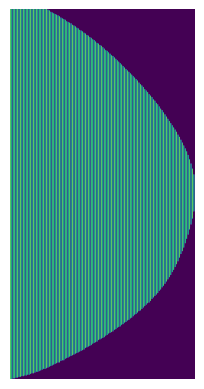

feature {'index': 1, 'radius': 7563.042895726867, 'texture': 42.45663026520349, 'perimeter': 47520.0, 'area': 47776, 'smoothness': 47265.37173476222, 'compactness': 47265.37173476222, 'concavity': 47707, 'concave_points': -94971, 'symmetry': 46.4423828125, 'fractal_dimension': 0.6177648409270842, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/3612659.png'}
feature_array [{'index': 0, 'radius': 7524.527399498628, 'texture': 42.42540183053534, 'perimeter': 47278.0, 'area': 47534, 'smoothness': 47023.378718391046, 'compactness': 47023.378718391046, 'concavity': 47461, 'concave_points': -94483, 'symmetry': 46.220703125, 'fractal_dimension': 0.6178219744855069, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/3612659.png'}, {'index': 1, 'radius': 7563.042895726867, 'texture': 42.45663026520349, 'perimeter': 47520.0, 'area

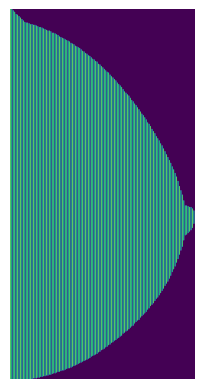

feature {'index': 1, 'radius': 7066.956938109429, 'texture': 75.56417611937341, 'perimeter': 44403.0, 'area': 44659, 'smoothness': 44148.467475760765, 'compactness': 44148.467475760765, 'concavity': 45150, 'concave_points': -89297, 'symmetry': 46.5517578125, 'fractal_dimension': 0.6185290297654279, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/5957358.png'}
feature_array [{'index': 0, 'radius': 7027.009047393363, 'texture': 75.77707640556191, 'perimeter': 44152.0, 'area': 44408, 'smoothness': 43897.47577013151, 'compactness': 43897.47577013151, 'concavity': 44930, 'concave_points': -88826, 'symmetry': 46.33203125, 'fractal_dimension': 0.6185933763449523, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/5957358.png'}, {'index': 1, 'radius': 7066.956938109429, 'texture': 75.56417611937341, 'perimeter': 44403.0, 'area'

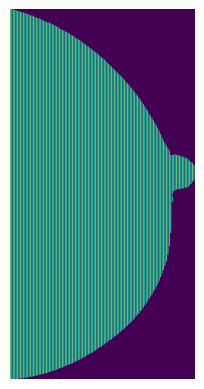

feature {'index': 1, 'radius': 7059.635810727202, 'texture': 56.13731763285081, 'perimeter': 44357.0, 'area': 44615, 'smoothness': 44100.491964585904, 'compactness': 44100.491964585904, 'concavity': 46452, 'concave_points': -90555, 'symmetry': 44.583984375, 'fractal_dimension': 0.6185428841717111, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/5759239.png'}
feature_array [{'index': 0, 'radius': 7018.732990352584, 'texture': 56.29544328364266, 'perimeter': 44100.0, 'area': 44358, 'smoothness': 43843.50060868389, 'compactness': 43843.50060868389, 'concavity': 46240, 'concave_points': -90086, 'symmetry': 44.37890625, 'fractal_dimension': 0.6186088705784414, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_false/5759239.png'}, {'index': 1, 'radius': 7059.635810727202, 'texture': 56.13731763285081, 'perimeter': 44357.0, 'area':

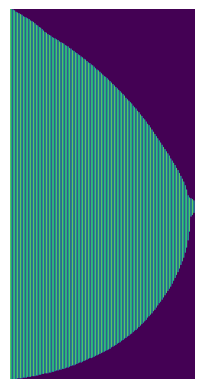

feature {'index': 1, 'radius': 7121.547083589949, 'texture': 48.79062533424363, 'perimeter': 44746.0, 'area': 45002, 'smoothness': 44491.45629083152, 'compactness': 44491.45629083152, 'concavity': 45105, 'concave_points': -89595, 'symmetry': 49.0830078125, 'fractal_dimension': 0.6184418063539596, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_true/2979828.png'}
feature_array [{'index': 0, 'radius': 7079.211868727505, 'texture': 48.903026025203886, 'perimeter': 44480.0, 'area': 44736, 'smoothness': 44225.46494992847, 'compactness': 44225.46494992847, 'concavity': 44894, 'concave_points': -89118, 'symmetry': 48.849609375, 'fractal_dimension': 0.618509378180398, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_true/2979828.png'}, {'index': 1, 'radius': 7121.547083589949, 'texture': 48.79062533424363, 'perimeter': 44746.0, 'area': 4

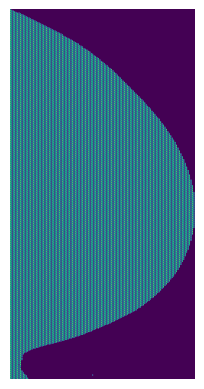

feature_array [{'index': 0, 'radius': 6925.9456585300095, 'texture': 39.364508562000424, 'perimeter': 43517.0, 'area': 43786, 'smoothness': 43249.65260585575, 'compactness': 43249.65260585575, 'concavity': 50918, 'concave_points': -94192, 'symmetry': 44.478515625, 'fractal_dimension': 0.6187720633272437, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_true/64750598.png'}]
feature_array []
feature {'index': 0, 'radius': 2073.6297535443045, 'texture': 32.392999734408384, 'perimeter': 13029.0, 'area': 13093, 'smoothness': 12965.312838921562, 'compactness': 12965.312838921562, 'concavity': 89604, 'concave_points': -102185, 'symmetry': 52.2607421875, 'fractal_dimension': 0.6338228123662617, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_true/52731467.png'}
labeled_image [[  0   0   0 ... 141 498 209]
 [  0   0   0 ... 141 498 209]
 

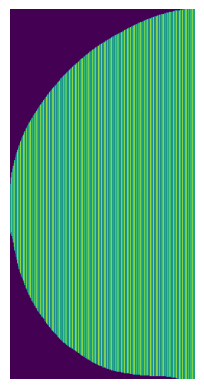

feature {'index': 1, 'radius': 2089.704402796586, 'texture': 32.350803576879194, 'perimeter': 13130.0, 'area': 13195, 'smoothness': 13065.320197044335, 'compactness': 13065.320197044335, 'concavity': 90254, 'concave_points': -102937, 'symmetry': 52.609375, 'fractal_dimension': 0.6337158494828576, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_true/52731467.png'}
feature {'index': 2, 'radius': 2055.6452449749204, 'texture': 32.5077482964867, 'perimeter': 12916.0, 'area': 12980, 'smoothness': 12852.315562403697, 'compactness': 12852.315562403697, 'concavity': 88891, 'concave_points': -101359, 'symmetry': 51.8916015625, 'fractal_dimension': 0.633948214505191, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_true/52731467.png'}
feature {'index': 3, 'radius': 2037.0241166331684, 'texture': 32.68055784183539, 'perimeter': 12799.0, 'ar

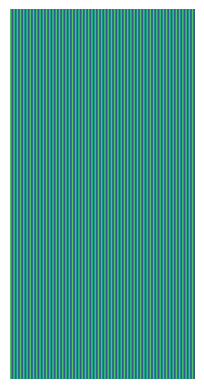

feature {'index': 1, 'radius': 10389.634685038927, 'texture': 69.7077680339859, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'compactness': 65025.0, 'concavity': 65024, 'concave_points': -130048, 'symmetry': 57.46484375, 'fractal_dimension': 0.6143260559750294, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_true/32033063.png'}
feature_array [{'index': 0, 'radius': 10389.634685038927, 'texture': 69.89139872408938, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'compactness': 65025.0, 'concavity': 65024, 'concave_points': -130048, 'symmetry': 57.3828125, 'fractal_dimension': 0.6143260559750294, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_cc_true/32033063.png'}, {'index': 1, 'radius': 10389.634685038927, 'texture': 69.7077680339859, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'compactne

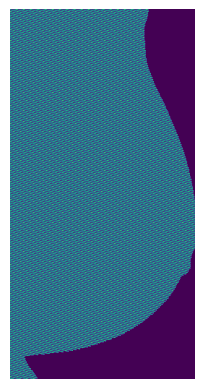

feature_array [{'index': 0, 'radius': 1645.0254917978302, 'texture': 48.139723662185375, 'perimeter': 10336.0, 'area': 31350, 'smoothness': 3407.7478787878786, 'compactness': 3407.7478787878786, 'concavity': 77483, 'concave_points': -108321, 'symmetry': 55.6162109375, 'fractal_dimension': 0.6969302531705196, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/84833951.png'}]
feature {'index': 0, 'radius': 609.0812821285926, 'texture': 58.44443575689929, 'perimeter': 3826.9705627484773, 'area': 8618, 'smoothness': 1699.4318505620095, 'compactness': 1699.4318505620095, 'concavity': 86144, 'concave_points': -94252, 'symmetry': 57.99609375, 'fractal_dimension': 0.7025983723694303, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/39672040.png'}
labeled_image [[133  10  10 ...   0   0   0]
 [336  80 133 ...   0   0   0]
 [334  

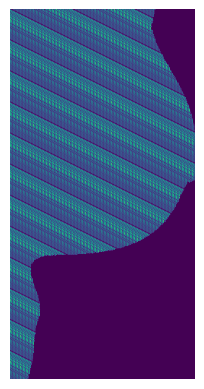

feature_array [{'index': 0, 'radius': 609.0812821285926, 'texture': 58.44443575689929, 'perimeter': 3826.9705627484773, 'area': 8618, 'smoothness': 1699.4318505620095, 'compactness': 1699.4318505620095, 'concavity': 86144, 'concave_points': -94252, 'symmetry': 57.99609375, 'fractal_dimension': 0.7025983723694303, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/39672040.png'}]
feature_array []
feature_array []
feature {'index': 0, 'radius': 7258.959205009448, 'texture': 62.1730415561666, 'perimeter': 45609.38582233137, 'area': 52114, 'smoothness': 39916.645720733046, 'compactness': 39916.645720733046, 'concavity': 49989, 'concave_points': -101591, 'symmetry': 50.70703125, 'fractal_dimension': 0.6241786415178662, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/139396228.png'}
labeled_image [[207  10  10 ...   0   0   0

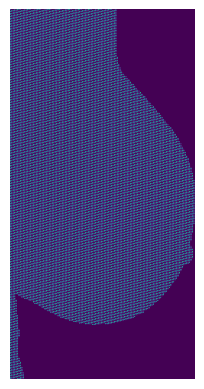

feature_array [{'index': 0, 'radius': 7258.959205009448, 'texture': 62.1730415561666, 'perimeter': 45609.38582233137, 'area': 52114, 'smoothness': 39916.645720733046, 'compactness': 39916.645720733046, 'concavity': 49989, 'concave_points': -101591, 'symmetry': 50.70703125, 'fractal_dimension': 0.6241786415178662, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/139396228.png'}]
feature_array []
feature_array []
feature {'index': 0, 'radius': 8407.678178715556, 'texture': 58.10600759706069, 'perimeter': 52827.0, 'area': 53087, 'smoothness': 52568.27338143048, 'compactness': 52568.27338143048, 'concavity': 54180, 'concave_points': -106755, 'symmetry': 54.587890625, 'fractal_dimension': 0.6165970454684115, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/4493744.png'}
labeled_image [[286  10 286 ...   0   0   0]
 [286  10

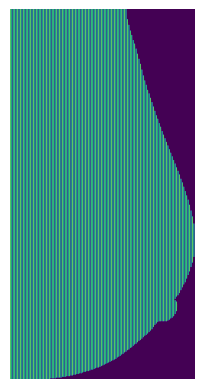

feature {'index': 1, 'radius': 8447.307759545438, 'texture': 57.74463257009805, 'perimeter': 53076.0, 'area': 53336, 'smoothness': 52817.26743662817, 'compactness': 52817.26743662817, 'concavity': 54533, 'concave_points': -107357, 'symmetry': 54.794921875, 'fractal_dimension': 0.6165455928893336, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/4493744.png'}
feature_array [{'index': 0, 'radius': 8407.678178715556, 'texture': 58.10600759706069, 'perimeter': 52827.0, 'area': 53087, 'smoothness': 52568.27338143048, 'compactness': 52568.27338143048, 'concavity': 54180, 'concave_points': -106755, 'symmetry': 54.587890625, 'fractal_dimension': 0.6165970454684115, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/4493744.png'}, {'index': 1, 'radius': 8447.307759545438, 'texture': 57.74463257009805, 'perimeter': 53076.0, 'area'

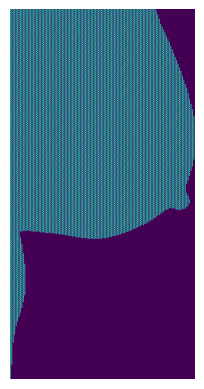

feature_array [{'index': 0, 'radius': 5976.586422986854, 'texture': 58.13872517999146, 'perimeter': 37552.0, 'area': 37822, 'smoothness': 37283.92744963249, 'compactness': 37283.92744963249, 'concavity': 55960, 'concave_points': -93279, 'symmetry': 58.4111328125, 'fractal_dimension': 0.6204819342503676, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/111055050.png'}]
feature {'index': 0, 'radius': 4104.865388785725, 'texture': 45.25544496437862, 'perimeter': 25791.62989876849, 'area': 32241, 'smoothness': 20632.36788049529, 'compactness': 20632.36788049529, 'concavity': 70512, 'concave_points': -102241, 'symmetry': 51.296875, 'fractal_dimension': 0.6355712717730122, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/42886513.png'}
labeled_image [[215  10  10 ...   0   0   0]
 [473  10 498 ...   0   0   0]
 [115 196 173 

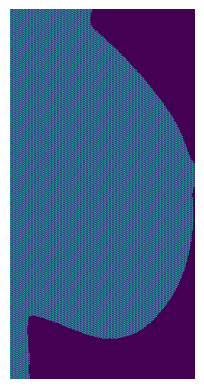

feature_array [{'index': 0, 'radius': 4104.865388785725, 'texture': 45.25544496437862, 'perimeter': 25791.62989876849, 'area': 32241, 'smoothness': 20632.36788049529, 'compactness': 20632.36788049529, 'concavity': 70512, 'concave_points': -102241, 'symmetry': 51.296875, 'fractal_dimension': 0.6355712717730122, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/42886513.png'}]
feature {'index': 0, 'radius': 3457.800293614518, 'texture': 45.213271955494825, 'perimeter': 21726.0, 'area': 21854, 'smoothness': 21598.74970257161, 'compactness': 21598.74970257161, 'concavity': 71782, 'concave_points': -93124, 'symmetry': 50.2109375, 'fractal_dimension': 0.6270193873005924, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/159974570.png'}
labeled_image [[206  10 228 ...   0   0   0]
 [206  10 228 ...   0   0   0]
 [206  10 228 ..

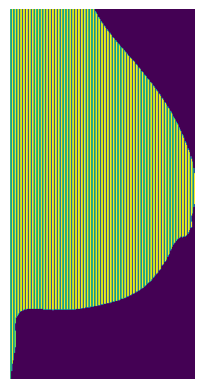

feature {'index': 1, 'radius': 3471.805928606605, 'texture': 45.62345241908762, 'perimeter': 21814.0, 'area': 21942, 'smoothness': 21686.746695834474, 'compactness': 21686.746695834474, 'concavity': 72054, 'concave_points': -93484, 'symmetry': 50.419921875, 'fractal_dimension': 0.6269668103179482, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/159974570.png'}
feature {'index': 2, 'radius': 3439.9749399882257, 'texture': 44.756712860670845, 'perimeter': 21614.0, 'area': 21742, 'smoothness': 21486.75356452948, 'compactness': 21486.75356452948, 'concavity': 70508, 'concave_points': -91749, 'symmetry': 48.4873046875, 'fractal_dimension': 0.6270866812965575, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/159974570.png'}
feature {'index': 3, 'radius': 3418.170712784636, 'texture': 44.32389853781645, 'perimeter': 21477.0,

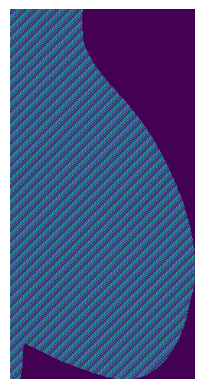

feature_array [{'index': 0, 'radius': 521.2324386259572, 'texture': 45.04895477474487, 'perimeter': 3275.0, 'area': 16598, 'smoothness': 646.1998433546211, 'compactness': 646.1998433546211, 'concavity': 88328, 'concave_points': -104414, 'symmetry': 59.4443359375, 'fractal_dimension': 0.7566068101972347, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/109324028.png'}]
feature_array []
feature_array []
feature {'index': 0, 'radius': 7956.31476010694, 'texture': 72.1765688459198, 'perimeter': 49991.0, 'area': 50261, 'smoothness': 49722.45042876186, 'compactness': 49722.45042876186, 'concavity': 53168, 'concave_points': -102917, 'symmetry': 55.1162109375, 'fractal_dimension': 0.6172137182602907, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/144780883.png'}
labeled_image [[227  10 501 ...   0   0   0]
 [227  10 501 ... 

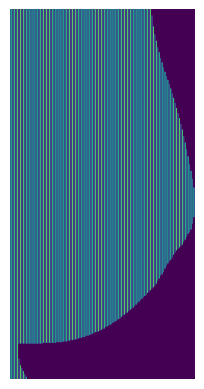

feature {'index': 1, 'radius': 4015.9566790377953, 'texture': 71.29718304354346, 'perimeter': 25233.0, 'area': 25367, 'smoothness': 25099.70784877991, 'compactness': 25099.70784877991, 'concavity': 78192, 'concave_points': -103047, 'symmetry': 55.26953125, 'fractal_dimension': 0.6251156145504988, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/144780883.png'}
feature {'index': 2, 'radius': 3979.669352012843, 'texture': 71.94653570163814, 'perimeter': 25005.0, 'area': 25139, 'smoothness': 24871.714268666216, 'compactness': 24871.714268666216, 'concavity': 77618, 'concave_points': -102245, 'symmetry': 54.8408203125, 'fractal_dimension': 0.6252301359734417, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/144780883.png'}
feature_array [{'index': 0, 'radius': 7956.31476010694, 'texture': 72.1765688459198, 'perimeter': 499

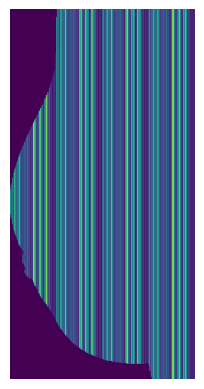

feature {'index': 1, 'radius': 277.56622075226545, 'texture': 42.43850430029707, 'perimeter': 1744.0, 'area': 1752, 'smoothness': 1736.0365296803652, 'compactness': 1736.0365296803652, 'concavity': 85943, 'concave_points': -87183, 'symmetry': 46.1123046875, 'fractal_dimension': 0.6698568093731228, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/125432531.png'}
feature {'index': 2, 'radius': 282.81833387429805, 'texture': 41.788971051335565, 'perimeter': 1777.0, 'area': 1785, 'smoothness': 1769.0358543417367, 'compactness': 1769.0358543417367, 'concavity': 87224, 'concave_points': -88497, 'symmetry': 46.939453125, 'fractal_dimension': 0.669425626483819, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_l_mlo_true/125432531.png'}
feature {'index': 3, 'radius': 291.2535458581685, 'texture': 40.99201015450278, 'perimeter': 1830.0, 'a

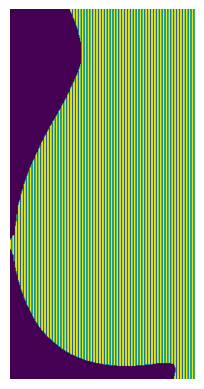

feature {'index': 1, 'radius': 8201.57252741155, 'texture': 55.63242327010057, 'perimeter': 51532.0, 'area': 51806, 'smoothness': 51259.449175771144, 'compactness': 51259.449175771144, 'concavity': 57144, 'concave_points': -108438, 'symmetry': 54.8359375, 'fractal_dimension': 0.6168818896161609, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/2834153.png'}
feature {'index': 2, 'radius': 4059.2468235587908, 'texture': 55.93699410668553, 'perimeter': 25505.0, 'area': 25643, 'smoothness': 25367.74265881527, 'compactness': 25367.74265881527, 'concavity': 81653, 'concave_points': -106784, 'symmetry': 54.12890625, 'fractal_dimension': 0.6249883171993257, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/2834153.png'}
feature_array [{'index': 0, 'radius': 4101.422883478143, 'texture': 55.374984579988926, 'perimeter': 25770.

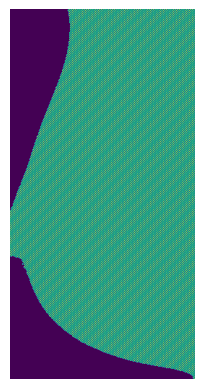

feature_array [{'index': 0, 'radius': 7627.254751403964, 'texture': 48.396011346676325, 'perimeter': 47923.45498813708, 'area': 34344, 'smoothness': 66872.1621826229, 'compactness': 66872.1621826229, 'concavity': 72065, 'concave_points': -105897, 'symmetry': 54.2880859375, 'fractal_dimension': 0.6019659016887747, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1564437.png'}]
feature {'index': 0, 'radius': 1739.722682937508, 'texture': 73.11811095671261, 'perimeter': 10931.0, 'area': 11003, 'smoothness': 10859.47114423339, 'compactness': 10859.47114423339, 'concavity': 89903, 'concave_points': -100394, 'symmetry': 58.513671875, 'fractal_dimension': 0.6364389564263193, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3897493.png'}
labeled_image [[ 10 245 489 ... 245 469 245]
 [ 10 245 489 ... 245 469 245]
 [ 10 245 48

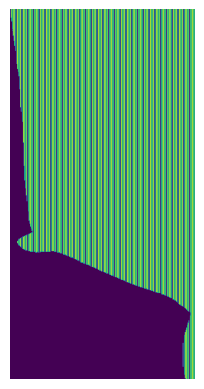

feature {'index': 1, 'radius': 7121.547083589949, 'texture': 72.82952674348131, 'perimeter': 44746.0, 'area': 45035, 'smoothness': 44458.85457977129, 'compactness': 44458.85457977129, 'concavity': 60559, 'concave_points': -105082, 'symmetry': 60.2392578125, 'fractal_dimension': 0.6184760321742714, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3897493.png'}
feature {'index': 2, 'radius': 1799.7240964831526, 'texture': 72.35504280329448, 'perimeter': 11308.0, 'area': 11380, 'smoothness': 11236.45553602812, 'compactness': 11236.45553602812, 'concavity': 92209, 'concave_points': -103077, 'symmetry': 59.85546875, 'fractal_dimension': 0.6359315866643247, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3897493.png'}
feature {'index': 3, 'radius': 1780.9438131983088, 'texture': 72.61159767762548, 'perimeter': 11190.0, 'a

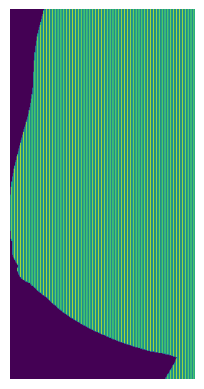

feature {'index': 1, 'radius': 8493.940157871362, 'texture': 59.08745816014907, 'perimeter': 53369.0, 'area': 53641, 'smoothness': 53098.37924348912, 'compactness': 53098.37924348912, 'concavity': 56172, 'concave_points': -109301, 'symmetry': 57.611328125, 'fractal_dimension': 0.6164956964846381, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/2266100.png'}
feature {'index': 2, 'radius': 4244.980642147033, 'texture': 58.82544618943934, 'perimeter': 26672.0, 'area': 26810, 'smoothness': 26534.710331965685, 'compactness': 26534.710331965685, 'concavity': 82142, 'concave_points': -108440, 'symmetry': 57.3037109375, 'fractal_dimension': 0.6244280686261631, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/2266100.png'}
feature_array [{'index': 0, 'radius': 4209.011625008264, 'texture': 59.49525918439554, 'perimeter': 264

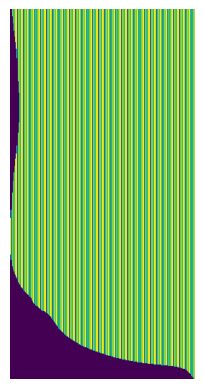

feature {'index': 1, 'radius': 2297.2424485884176, 'texture': 56.46594247941426, 'perimeter': 14434.0, 'area': 14502, 'smoothness': 14366.31885257206, 'compactness': 14366.31885257206, 'concavity': 101091, 'concave_points': -115084, 'symmetry': 60.5751953125, 'fractal_dimension': 0.6323814233955452, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3738655.png'}
feature {'index': 2, 'radius': 2316.500196702537, 'texture': 56.39371191455636, 'perimeter': 14555.0, 'area': 14621, 'smoothness': 14489.297927638328, 'compactness': 14489.297927638328, 'concavity': 101345, 'concave_points': -115454, 'symmetry': 61.265625, 'fractal_dimension': 0.632256966334686, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3738655.png'}
feature {'index': 3, 'radius': 9182.126131800718, 'texture': 58.25761052106349, 'perimeter': 57693.0, 'a

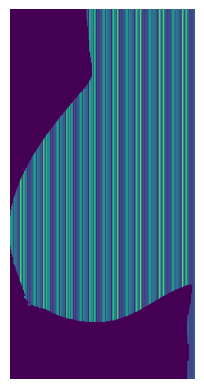

feature {'index': 1, 'radius': 418.57750033168475, 'texture': 47.18407413760279, 'perimeter': 2630.0, 'area': 2648, 'smoothness': 2612.1223564954685, 'compactness': 2612.1223564954685, 'concavity': 79131, 'concave_points': -81346, 'symmetry': 45.638671875, 'fractal_dimension': 0.6611383563642185, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/754923.png'}
feature {'index': 2, 'radius': 456.29722184446393, 'texture': 48.85769834315972, 'perimeter': 2867.0, 'area': 2885, 'smoothness': 2849.1123050259966, 'compactness': 2849.1123050259966, 'concavity': 89598, 'concave_points': -91971, 'symmetry': 48.3720703125, 'fractal_dimension': 0.6593566209374979, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/754923.png'}
feature {'index': 3, 'radius': 437.6760935027122, 'texture': 47.14361706376367, 'perimeter': 2750.0, 'area'

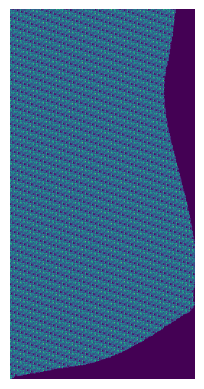

feature_array [{'index': 0, 'radius': 722.4429041588631, 'texture': 39.202644796666576, 'perimeter': 4539.242640687119, 'area': 15224, 'smoothness': 1353.4369253174048, 'compactness': 1353.4369253174048, 'concavity': 101924, 'concave_points': -116638, 'symmetry': 60.166015625, 'fractal_dimension': 0.7221441915740028, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1017412.png'}]
feature {'index': 0, 'radius': 3631.597491470868, 'texture': 67.1635295325643, 'perimeter': 22818.0, 'area': 22950, 'smoothness': 22686.759215686274, 'compactness': 22686.759215686274, 'concavity': 72892, 'concave_points': -95330, 'symmetry': 49.3447265625, 'fractal_dimension': 0.6263933926809524, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3340686.png'}
labeled_image [[  0   0   0 ... 245  10 245]
 [  0   0   0 ... 245  10 245]
 [  0  

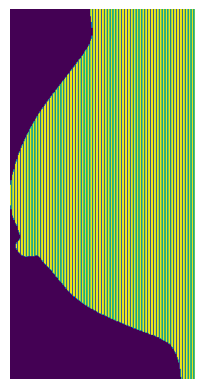

feature {'index': 1, 'radius': 3592.127065584078, 'texture': 67.55550027489149, 'perimeter': 22570.0, 'area': 22704, 'smoothness': 22436.79087385483, 'compactness': 22436.79087385483, 'concavity': 72289, 'concave_points': -94481, 'symmetry': 48.8857421875, 'fractal_dimension': 0.6265387270204067, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3340686.png'}
feature {'index': 2, 'radius': 7261.762588453908, 'texture': 67.22290746539146, 'perimeter': 45627.0, 'area': 45893, 'smoothness': 45362.54176018129, 'compactness': 45362.54176018129, 'concavity': 50817, 'concave_points': -96198, 'symmetry': 49.6025390625, 'fractal_dimension': 0.6182315864978798, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3340686.png'}
feature_array [{'index': 0, 'radius': 3631.597491470868, 'texture': 67.1635295325643, 'perimeter': 22818.0

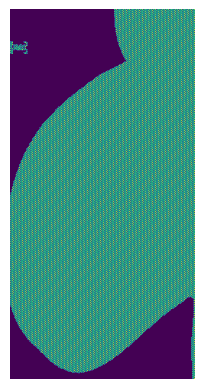

feature_array [{'index': 0, 'radius': 7249.572056776058, 'texture': 45.63910203522768, 'perimeter': 45550.40463047502, 'area': 32685, 'smoothness': 63479.86421906074, 'compactness': 63479.86421906074, 'concavity': 90747, 'concave_points': -122920, 'symmetry': 59.1953125, 'fractal_dimension': 0.6025080718240929, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/4419843.png'}]
feature_array []
feature_array []
feature {'index': 0, 'radius': 4218.083456764502, 'texture': 44.81323915034714, 'perimeter': 26503.0, 'area': 26633, 'smoothness': 26373.63455112079, 'compactness': 26373.63455112079, 'concavity': 81938, 'concave_points': -108059, 'symmetry': 55.0166015625, 'fractal_dimension': 0.6244925906406036, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3095401.png'}
labeled_image [[  0   0   0 ... 245 493 245]
 [  0   0 

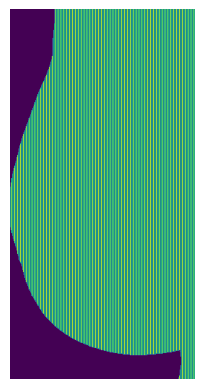

feature {'index': 1, 'radius': 8507.627482977265, 'texture': 44.93231122101885, 'perimeter': 53455.0, 'area': 53716, 'smoothness': 53195.26816963289, 'compactness': 53195.26816963289, 'concavity': 56484, 'concave_points': -109688, 'symmetry': 55.7177734375, 'fractal_dimension': 0.616468687898563, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3095401.png'}
feature {'index': 2, 'radius': 4253.8933189601785, 'texture': 44.73418680691704, 'perimeter': 26728.0, 'area': 26858, 'smoothness': 26598.629235237175, 'compactness': 26598.629235237175, 'concavity': 82804, 'concave_points': -109150, 'symmetry': 55.419921875, 'fractal_dimension': 0.6243873293573772, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3095401.png'}
feature_array [{'index': 0, 'radius': 4218.083456764502, 'texture': 44.81323915034714, 'perimeter': 265

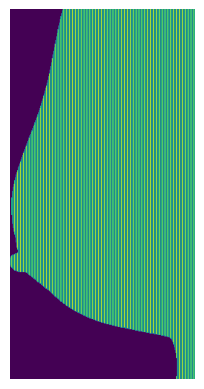

feature {'index': 1, 'radius': 7842.99644062551, 'texture': 70.26301771990866, 'perimeter': 49279.0, 'area': 49543, 'smoothness': 49016.40677795047, 'compactness': 49016.40677795047, 'concavity': 54151, 'concave_points': -103182, 'symmetry': 54.7265625, 'fractal_dimension': 0.6173673179022551, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1050256.png'}
feature {'index': 2, 'radius': 3919.6679384671984, 'texture': 70.05931278157034, 'perimeter': 24628.0, 'area': 24764, 'smoothness': 24492.746890647715, 'compactness': 24492.746890647715, 'concavity': 78422, 'concave_points': -102674, 'symmetry': 54.4638671875, 'fractal_dimension': 0.6254263108990372, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1050256.png'}
feature_array [{'index': 0, 'radius': 3880.834132352776, 'texture': 70.43600131879776, 'perimeter': 24384

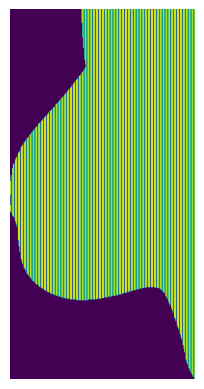

feature {'index': 1, 'radius': 3386.658034052441, 'texture': 48.185433466044984, 'perimeter': 21279.0, 'area': 21413, 'smoothness': 21145.838556017374, 'compactness': 21145.838556017374, 'concavity': 76237, 'concave_points': -97143, 'symmetry': 48.7626953125, 'fractal_dimension': 0.6273045965425446, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1825341.png'}
feature {'index': 2, 'radius': 6854.007624252473, 'texture': 48.410087411789725, 'perimeter': 43065.0, 'area': 43327, 'smoothness': 42804.58432386272, 'compactness': 42804.58432386272, 'concavity': 56245, 'concave_points': -99060, 'symmetry': 49.8173828125, 'fractal_dimension': 0.618883733392206, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1825341.png'}
feature_array [{'index': 0, 'radius': 3426.7650797115984, 'texture': 48.275245327219956, 'perimeter': 2

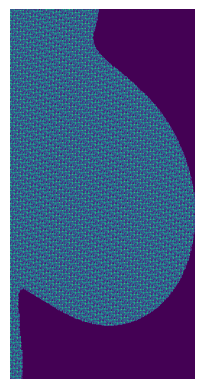

feature_array [{'index': 0, 'radius': 513.952730293877, 'texture': 46.19017503194279, 'perimeter': 3229.2602435673207, 'area': 9485, 'smoothness': 1099.4329700247201, 'compactness': 1099.4329700247201, 'concavity': 90174, 'concave_points': -99147, 'symmetry': 50.015625, 'fractal_dimension': 0.7232969697490909, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/3811186.png'}]
feature {'index': 0, 'radius': 3883.3806114422464, 'texture': 41.64564877422829, 'perimeter': 24400.0, 'area': 24534, 'smoothness': 24266.731882285807, 'compactness': 24266.731882285807, 'concavity': 92696, 'concave_points': -116718, 'symmetry': 54.267578125, 'fractal_dimension': 0.6255402918619406, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1190628.png'}
labeled_image [[244  10 302 ...   0   0   0]
 [244  10 302 ...   0   0   0]
 [244  10 30

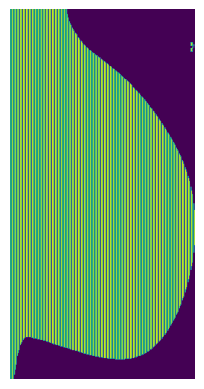

feature {'index': 1, 'radius': 3900.2510354099873, 'texture': 42.049255229498485, 'perimeter': 24506.0, 'area': 24640, 'smoothness': 24372.728733766235, 'compactness': 24372.728733766235, 'concavity': 92730, 'concave_points': -116858, 'symmetry': 54.423828125, 'fractal_dimension': 0.6254852775845864, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1190628.png'}
feature {'index': 2, 'radius': 3843.7510306123645, 'texture': 41.05533089956928, 'perimeter': 24151.0, 'area': 24283, 'smoothness': 24019.717539019068, 'compactness': 24019.717539019068, 'concavity': 91935, 'concave_points': -115706, 'symmetry': 53.8857421875, 'fractal_dimension': 0.6256665974189356, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_false/1190628.png'}
feature {'index': 3, 'radius': 3865.2369479297704, 'texture': 41.31936978522473, 'perimeter': 2428

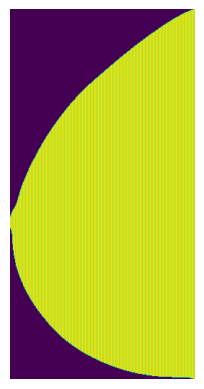

feature {'index': 1, 'radius': 7412.16400967575, 'texture': 49.75147028740491, 'perimeter': 46572.0, 'area': 46828, 'smoothness': 46317.39950456991, 'compactness': 46317.39950456991, 'concavity': 46872, 'concave_points': -93188, 'symmetry': 51.96875, 'fractal_dimension': 0.6179906933898319, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/22058316.png'}
feature_array [{'index': 0, 'radius': 7453.066830050367, 'texture': 49.57628294387415, 'perimeter': 46829.0, 'area': 47085, 'smoothness': 46574.39186577466, 'compactness': 46574.39186577466, 'concavity': 47105, 'concave_points': -93678, 'symmetry': 52.193359375, 'fractal_dimension': 0.6179289202952909, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/22058316.png'}, {'index': 1, 'radius': 7412.16400967575, 'texture': 49.75147028740491, 'perimeter': 46572.0, 'area': 46828,

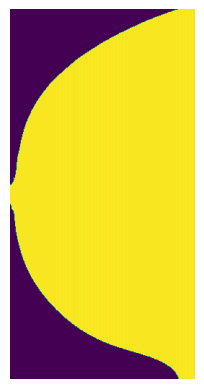

feature {'index': 1, 'radius': 7691.321779858934, 'texture': 33.0249329770999, 'perimeter': 48326.0, 'area': 48582, 'smoothness': 48071.34897698736, 'compactness': 48071.34897698736, 'concavity': 49388, 'concave_points': -97458, 'symmetry': 46.7939453125, 'fractal_dimension': 0.6175770577074532, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/86117089.png'}
feature_array [{'index': 0, 'radius': 7729.678121144081, 'texture': 32.96886587657575, 'perimeter': 48567.0, 'area': 48825, 'smoothness': 48310.36331797235, 'compactness': 48310.36331797235, 'concavity': 49597, 'concave_points': -97910, 'symmetry': 47.021484375, 'fractal_dimension': 0.6175235405303263, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/86117089.png'}, {'index': 1, 'radius': 7691.321779858934, 'texture': 33.0249329770999, 'perimeter': 48326.0, 'area': 4

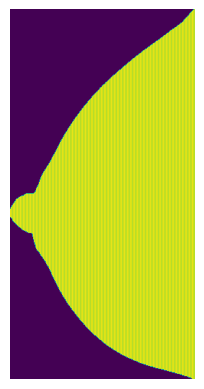

feature {'index': 1, 'radius': 6263.701940324633, 'texture': 64.62034033807127, 'perimeter': 39356.0, 'area': 39612, 'smoothness': 39101.65444814703, 'compactness': 39101.65444814703, 'concavity': 41189, 'concave_points': -80289, 'symmetry': 43.1513671875, 'fractal_dimension': 0.6199154576602616, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/55676960.png'}
feature_array [{'index': 0, 'radius': 6304.445605756158, 'texture': 64.54421217655724, 'perimeter': 39612.0, 'area': 39868, 'smoothness': 39357.64382462125, 'compactness': 39357.64382462125, 'concavity': 41385, 'concave_points': -80741, 'symmetry': 43.3857421875, 'fractal_dimension': 0.6198400459900841, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/55676960.png'}, {'index': 1, 'radius': 6263.701940324633, 'texture': 64.62034033807127, 'perimeter': 39356.0, 'area'

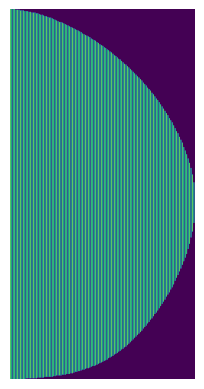

feature {'index': 1, 'radius': 8003.583778205233, 'texture': 37.624571051880146, 'perimeter': 50288.0, 'area': 50544, 'smoothness': 50033.296612852166, 'compactness': 50033.296612852166, 'concavity': 50483, 'concave_points': -100515, 'symmetry': 50.9111328125, 'fractal_dimension': 0.6171353246256525, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/63956271.png'}
feature_array [{'index': 0, 'radius': 7963.158422659892, 'texture': 37.625889068790244, 'perimeter': 50034.0, 'area': 50290, 'smoothness': 49779.303161662356, 'compactness': 49779.303161662356, 'concavity': 50257, 'concave_points': -100035, 'symmetry': 50.6923828125, 'fractal_dimension': 0.6171913291620438, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/63956271.png'}, {'index': 1, 'radius': 8003.583778205233, 'texture': 37.624571051880146, 'perimeter': 50288.

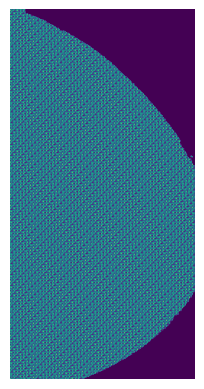

feature_array [{'index': 0, 'radius': 274.0648120042438, 'texture': 42.88851312900807, 'perimeter': 1722.0, 'area': 12088, 'smoothness': 245.3080741230973, 'compactness': 245.3080741230973, 'concavity': 91110, 'concave_points': -102686, 'symmetry': 55.83984375, 'fractal_dimension': 0.8006043324939875, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/88710137.png'}]
feature {'index': 0, 'radius': 7955.200675505297, 'texture': 50.158636939083515, 'perimeter': 49984.0, 'area': 50240, 'smoothness': 49729.30445859872, 'compactness': 49729.30445859872, 'concavity': 50407, 'concave_points': -100135, 'symmetry': 49.869140625, 'fractal_dimension': 0.6172023940685831, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/57015221.png'}
labeled_image [[  0   0   0 ... 245 273 245]
 [  0   0   0 ... 245 273 245]
 [  0   0   0 ... 245 273

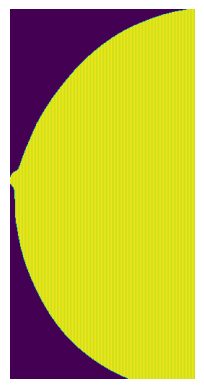

feature {'index': 1, 'radius': 7915.571094675415, 'texture': 50.422500609260844, 'perimeter': 49735.0, 'area': 49991, 'smoothness': 49480.310955972076, 'compactness': 49480.310955972076, 'concavity': 50197, 'concave_points': -99676, 'symmetry': 49.640625, 'fractal_dimension': 0.6172576967813735, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/57015221.png'}
feature_array [{'index': 0, 'radius': 7955.200675505297, 'texture': 50.158636939083515, 'perimeter': 49984.0, 'area': 50240, 'smoothness': 49729.30445859872, 'compactness': 49729.30445859872, 'concavity': 50407, 'concave_points': -100135, 'symmetry': 49.869140625, 'fractal_dimension': 0.6172023940685831, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/57015221.png'}, {'index': 1, 'radius': 7915.571094675415, 'texture': 50.422500609260844, 'perimeter': 49735.0, 'area

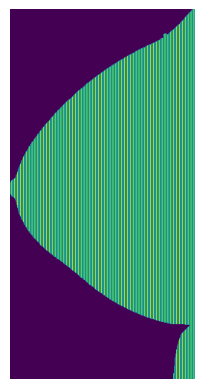

feature {'index': 1, 'radius': 5879.820217586982, 'texture': 79.80114834568846, 'perimeter': 36944.0, 'area': 37222, 'smoothness': 36668.07629896298, 'compactness': 36668.07629896298, 'concavity': 43097, 'concave_points': -79807, 'symmetry': 37.80859375, 'fractal_dimension': 0.620684734905014, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/58132425.png'}
feature {'index': 2, 'radius': 2939.7509538503987, 'texture': 79.78439291328006, 'perimeter': 18471.0, 'area': 18611, 'smoothness': 18332.053140615764, 'compactness': 18332.053140615764, 'concavity': 61169, 'concave_points': -79268, 'symmetry': 37.55859375, 'fractal_dimension': 0.6292032864630634, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/58132425.png'}
feature_array [{'index': 0, 'radius': 2900.121373020517, 'texture': 79.89033678052368, 'perimeter': 18222.0, '

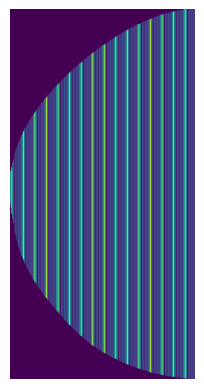

feature {'index': 1, 'radius': 992.1719152348755, 'texture': 43.46940876111991, 'perimeter': 6234.0, 'area': 6266, 'smoothness': 6202.1634216406, 'compactness': 6202.1634216406, 'concavity': 89191, 'concave_points': -94945, 'symmetry': 46.869140625, 'fractal_dimension': 0.6451253153717693, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/98489338.png'}
feature {'index': 2, 'radius': 974.1874066654914, 'texture': 43.96094444260239, 'perimeter': 6121.0, 'area': 6153, 'smoothness': 6089.166422883147, 'compactness': 6089.166422883147, 'concavity': 87732, 'concave_points': -93373, 'symmetry': 46.1181640625, 'fractal_dimension': 0.6454351814299525, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_true/98489338.png'}
feature {'index': 3, 'radius': 1000.7662821618379, 'texture': 43.231431763152024, 'perimeter': 6288.0, 'area': 6320, 

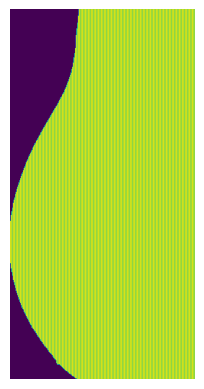

feature {'index': 1, 'radius': 8722.804966037507, 'texture': 63.669611537901254, 'perimeter': 54807.0, 'area': 55063, 'smoothness': 54552.190200316, 'compactness': 54552.190200316, 'concavity': 57170, 'concave_points': -111721, 'symmetry': 56.7998046875, 'fractal_dimension': 0.616192425292363, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/14104315.png'}
feature_array [{'index': 0, 'radius': 8760.365532607195, 'texture': 63.13635010849097, 'perimeter': 55043.0, 'area': 55299, 'smoothness': 54788.185120888265, 'compactness': 54788.185120888265, 'concavity': 57488, 'concave_points': -112275, 'symmetry': 56.98046875, 'fractal_dimension': 0.6161457758087722, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/14104315.png'}, {'index': 1, 'radius': 8722.804966037507, 'texture': 63.669611537901254, 'perimeter': 54807.0, 'area

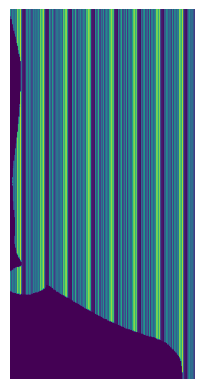

feature {'index': 1, 'radius': 547.9704690653957, 'texture': 40.12671956178327, 'perimeter': 3443.0, 'area': 3459, 'smoothness': 3427.0740098294305, 'compactness': 3427.0740098294305, 'concavity': 98579, 'concave_points': -101526, 'symmetry': 55.8818359375, 'fractal_dimension': 0.6556747259369754, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/68880663.png'}
feature {'index': 2, 'radius': 1100.3972765373644, 'texture': 40.44433170691679, 'perimeter': 6914.0, 'area': 6946, 'smoothness': 6882.147422977253, 'compactness': 6882.147422977253, 'concavity': 101748, 'concave_points': -108182, 'symmetry': 59.1064453125, 'fractal_dimension': 0.6433975106294126, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/68880663.png'}
feature {'index': 3, 'radius': 552.5859624150606, 'texture': 40.418948544859525, 'perimeter': 3472.0, 'a

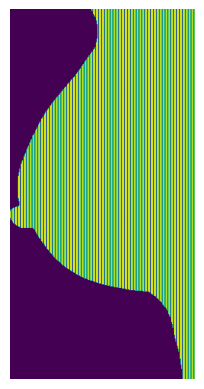

feature {'index': 1, 'radius': 3142.6735062925654, 'texture': 72.94682730323082, 'perimeter': 19746.0, 'area': 19881, 'smoothness': 19611.916704391126, 'compactness': 19611.916704391126, 'concavity': 69221, 'concave_points': -88590, 'symmetry': 46.986328125, 'fractal_dimension': 0.6282940648308645, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/101263956.png'}
feature {'index': 2, 'radius': 6367.630118163641, 'texture': 72.85209710044921, 'perimeter': 40009.0, 'area': 40275, 'smoothness': 39744.75682184978, 'compactness': 39744.75682184978, 'concavity': 50392, 'concave_points': -90155, 'symmetry': 47.7216796875, 'fractal_dimension': 0.6197359792053413, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/101263956.png'}
feature_array [{'index': 0, 'radius': 3183.5763266671825, 'texture': 72.8028939966873, 'perimeter': 20

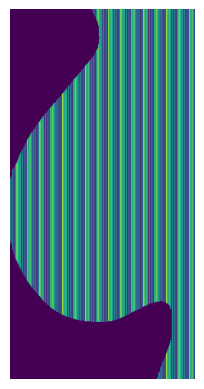

feature {'index': 1, 'radius': 947.1310663398692, 'texture': 49.24478448154004, 'perimeter': 5951.0, 'area': 5987, 'smoothness': 5915.216469016202, 'compactness': 5915.216469016202, 'concavity': 93833, 'concave_points': -99308, 'symmetry': 49.8701171875, 'fractal_dimension': 0.6459534924880636, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/111786935.png'}
feature {'index': 2, 'radius': 902.8859921603223, 'texture': 48.65688868812784, 'perimeter': 5673.0, 'area': 5709, 'smoothness': 5637.227009984235, 'compactness': 5637.227009984235, 'concavity': 90810, 'concave_points': -96007, 'symmetry': 48.1328125, 'fractal_dimension': 0.6467783806758785, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/111786935.png'}
feature {'index': 3, 'radius': 910.2071195425494, 'texture': 48.707820161501864, 'perimeter': 5719.0, 'area': 5

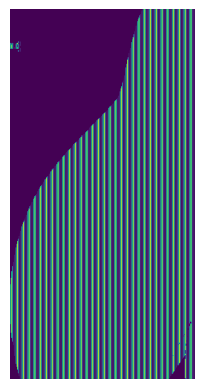

feature {'index': 1, 'radius': 1914.474810452409, 'texture': 41.59270134622621, 'perimeter': 12029.0, 'area': 12103, 'smoothness': 11955.452449805833, 'compactness': 11955.452449805833, 'concavity': 110814, 'concave_points': -122405, 'symmetry': 60.4306640625, 'fractal_dimension': 0.6350259054919835, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/94523874.png'}
feature {'index': 2, 'radius': 1930.3903047615986, 'texture': 42.38746481542805, 'perimeter': 12129.0, 'area': 12201, 'smoothness': 12057.424883206295, 'compactness': 12057.424883206295, 'concavity': 110786, 'concave_points': -122475, 'symmetry': 60.6923828125, 'fractal_dimension': 0.6348956304638158, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/94523874.png'}
feature {'index': 3, 'radius': 3788.524265359477, 'texture': 41.32193562841167, 'perimeter': 2380

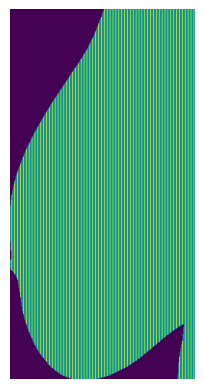

feature {'index': 1, 'radius': 8488.369734863147, 'texture': 59.60617233396729, 'perimeter': 53334.0, 'area': 53600, 'smoothness': 53069.32007462686, 'compactness': 53069.32007462686, 'concavity': 57830, 'concave_points': -110918, 'symmetry': 57.384765625, 'fractal_dimension': 0.6164977288625415, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/100791157.png'}
feature {'index': 2, 'radius': 4246.253881691768, 'texture': 59.383622826384865, 'perimeter': 26680.0, 'area': 26812, 'smoothness': 26548.649858272416, 'compactness': 26548.649858272416, 'concavity': 84006, 'concave_points': -110306, 'symmetry': 57.05859375, 'fractal_dimension': 0.6244133541815805, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/100791157.png'}
feature_array [{'index': 0, 'radius': 4206.9426107480695, 'texture': 60.19332880602243, 'perimeter': 2

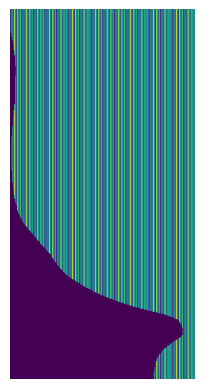

feature {'index': 1, 'radius': 997.5831833, 'texture': 55.65313918871094, 'perimeter': 6268.0, 'area': 6306, 'smoothness': 6230.228988265144, 'compactness': 6230.228988265144, 'concavity': 95358, 'concave_points': -101152, 'symmetry': 59.865234375, 'fractal_dimension': 0.6450878869507165, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/77581347.png'}
feature {'index': 2, 'radius': 1007.9282546009732, 'texture': 55.60413212393206, 'perimeter': 6333.0, 'area': 6371, 'smoothness': 6295.226652016951, 'compactness': 6295.226652016951, 'concavity': 95869, 'concave_points': -101728, 'symmetry': 59.85546875, 'fractal_dimension': 0.6449133563753485, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/77581347.png'}
feature {'index': 3, 'radius': 965.1155749092534, 'texture': 55.765715933269725, 'perimeter': 6064.0, 'area': 6102, 

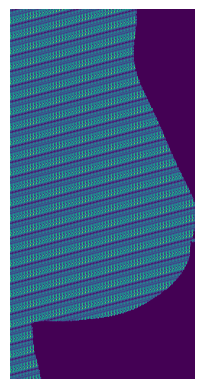

feature_array [{'index': 0, 'radius': 175.38874728726867, 'texture': 52.12761468539508, 'perimeter': 1102.0, 'area': 11152, 'smoothness': 108.89562410329985, 'compactness': 108.89562410329985, 'concavity': 91500, 'concave_points': -102140, 'symmetry': 52.896484375, 'fractal_dimension': 0.8458670965030319, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/156027166.png'}]
feature {'index': 0, 'radius': 1941.2128408918475, 'texture': 61.078267859679094, 'perimeter': 12197.0, 'area': 12263, 'smoothness': 12131.355214874011, 'compactness': 12131.355214874011, 'concavity': 90646, 'concave_points': -102397, 'symmetry': 53.9521484375, 'fractal_dimension': 0.6347877336580919, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/200271231.png'}
labeled_image [[  0   0   0 ... 245  77 245]
 [  0   0   0 ... 245  77 245]
 [  0   0   0

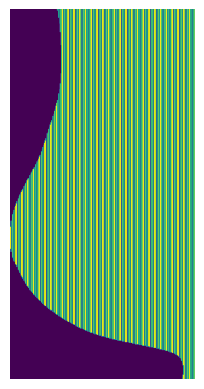

feature {'index': 1, 'radius': 1958.0832648595883, 'texture': 60.64202573265477, 'perimeter': 12303.0, 'area': 12369, 'smoothness': 12237.352170749455, 'compactness': 12237.352170749455, 'concavity': 91075, 'concave_points': -102932, 'symmetry': 54.3349609375, 'fractal_dimension': 0.6346614254913124, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/200271231.png'}
feature {'index': 2, 'radius': 1979.4100272339024, 'texture': 60.21317721661785, 'perimeter': 12437.0, 'area': 12505, 'smoothness': 12369.369772091164, 'compactness': 12369.369772091164, 'concavity': 91717, 'concave_points': -103710, 'symmetry': 54.697265625, 'fractal_dimension': 0.6345121400525735, 'label': 1, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_mlo_true/200271231.png'}
feature {'index': 3, 'radius': 7843.951370284062, 'texture': 61.02708817669531, 'perimeter': 4928

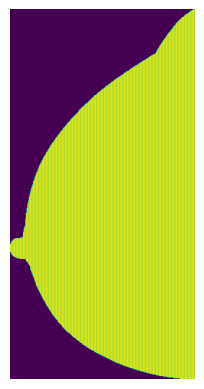

feature {'index': 1, 'radius': 6699.9456393395185, 'texture': 63.502575905864866, 'perimeter': 42097.0, 'area': 42353, 'smoothness': 41842.547375628645, 'compactness': 41842.547375628645, 'concavity': 44001, 'concave_points': -85842, 'symmetry': 47.9033203125, 'fractal_dimension': 0.6191374408267551, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/668503.png'}
feature_array [{'index': 0, 'radius': 6741.166769600319, 'texture': 63.359763296849415, 'perimeter': 42356.0, 'area': 42612, 'smoothness': 42101.53797052473, 'compactness': 42101.53797052473, 'concavity': 44220, 'concave_points': -86320, 'symmetry': 48.11328125, 'fractal_dimension': 0.6190671167628765, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/668503.png'}, {'index': 1, 'radius': 6699.9456393395185, 'texture': 63.502575905864866, 'perimeter': 42097.0, 'ar

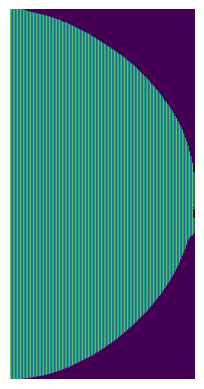

feature {'index': 1, 'radius': 7904.589403602074, 'texture': 42.604185879306, 'perimeter': 49666.0, 'area': 49926, 'smoothness': 49407.35400392581, 'compactness': 49407.35400392581, 'concavity': 49904, 'concave_points': -99318, 'symmetry': 46.8271484375, 'fractal_dimension': 0.6172767855998255, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/1113871.png'}
feature_array [{'index': 0, 'radius': 7862.4133436827215, 'texture': 42.8191370482087, 'perimeter': 49401.0, 'area': 49657, 'smoothness': 49146.31977364722, 'compactness': 49146.31977364722, 'concavity': 49684, 'concave_points': -98829, 'symmetry': 46.61328125, 'fractal_dimension': 0.6173324046254395, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/1113871.png'}, {'index': 1, 'radius': 7904.589403602074, 'texture': 42.604185879306, 'perimeter': 49666.0, 'area': 4992

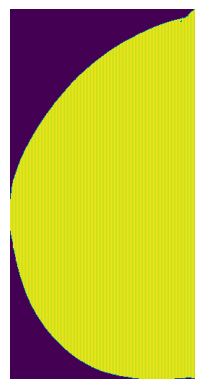

feature {'index': 1, 'radius': 7959.020394139502, 'texture': 36.46544181202152, 'perimeter': 50008.0, 'area': 50267, 'smoothness': 49750.33449380309, 'compactness': 49750.33449380309, 'concavity': 50354, 'concave_points': -100110, 'symmetry': 53.8408203125, 'fractal_dimension': 0.6171998392623688, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/1255338.png'}
feature_array [{'index': 0, 'radius': 7996.899270595373, 'texture': 36.48854208303661, 'perimeter': 50246.0, 'area': 50504, 'smoothness': 49989.317994614285, 'compactness': 49989.317994614285, 'concavity': 50578, 'concave_points': -100570, 'symmetry': 54.244140625, 'fractal_dimension': 0.617146390875945, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/1255338.png'}, {'index': 1, 'radius': 7959.020394139502, 'texture': 36.46544181202152, 'perimeter': 50008.0, 'are

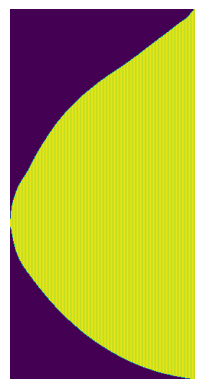

feature {'index': 1, 'radius': 6894.592134740907, 'texture': 63.22092173666856, 'perimeter': 43320.0, 'area': 43576, 'smoothness': 43065.50394712686, 'compactness': 43065.50394712686, 'concavity': 43903, 'concave_points': -86967, 'symmetry': 47.583984375, 'fractal_dimension': 0.6188098780736745, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/225973.png'}
feature_array [{'index': 0, 'radius': 6935.335800172432, 'texture': 63.073189342435974, 'perimeter': 43576.0, 'area': 43832, 'smoothness': 43321.49516335098, 'compactness': 43321.49516335098, 'concavity': 44097, 'concave_points': -87417, 'symmetry': 47.818359375, 'fractal_dimension': 0.6187427294937072, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/225973.png'}, {'index': 1, 'radius': 6894.592134740907, 'texture': 63.22092173666856, 'perimeter': 43320.0, 'area': 4

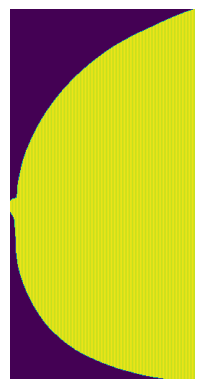

feature {'index': 1, 'radius': 7847.9302438613595, 'texture': 67.7237956303278, 'perimeter': 49310.0, 'area': 49566, 'smoothness': 49055.32219666707, 'compactness': 49055.32219666707, 'concavity': 49808, 'concave_points': -98862, 'symmetry': 51.744140625, 'fractal_dimension': 0.6173528648322343, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/2200839.png'}
feature_array [{'index': 0, 'radius': 7886.445740089598, 'texture': 67.38383356672466, 'perimeter': 49552.0, 'area': 49808, 'smoothness': 49297.31577256665, 'compactness': 49297.31577256665, 'concavity': 50016, 'concave_points': -99312, 'symmetry': 51.9609375, 'fractal_dimension': 0.6172985542936062, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/2200839.png'}, {'index': 1, 'radius': 7847.9302438613595, 'texture': 67.7237956303278, 'perimeter': 49310.0, 'area': 49

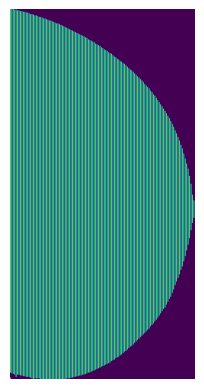

feature {'index': 1, 'radius': 8023.318991148628, 'texture': 33.37190773487338, 'perimeter': 50412.0, 'area': 50670, 'smoothness': 50155.31367673179, 'compactness': 50155.31367673179, 'concavity': 50785, 'concave_points': -100943, 'symmetry': 51.81640625, 'fractal_dimension': 0.6171099302724911, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/249677.png'}
feature_array [{'index': 0, 'radius': 7985.599269635849, 'texture': 33.30542685716692, 'perimeter': 50175.0, 'area': 50432, 'smoothness': 49919.30966449873, 'compactness': 49919.30966449873, 'concavity': 50566, 'concave_points': -100486, 'symmetry': 51.587890625, 'fractal_dimension': 0.6171611138401051, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/249677.png'}, {'index': 1, 'radius': 8023.318991148628, 'texture': 33.37190773487338, 'perimeter': 50412.0, 'area': 5

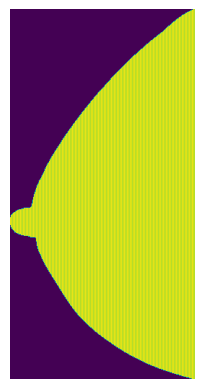

feature {'index': 1, 'radius': 6223.435739722384, 'texture': 73.32569518061753, 'perimeter': 39103.0, 'area': 39359, 'smoothness': 38848.66508295434, 'compactness': 38848.66508295434, 'concavity': 40700, 'concave_points': -79547, 'symmetry': 42.6357421875, 'fractal_dimension': 0.6199905735023614, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/790381.png'}
feature_array [{'index': 0, 'radius': 6265.452644698644, 'texture': 73.19749903111966, 'perimeter': 39367.0, 'area': 39623, 'smoothness': 39112.65398884486, 'compactness': 39112.65398884486, 'concavity': 40989, 'concave_points': -80100, 'symmetry': 42.869140625, 'fractal_dimension': 0.6199122050734823, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/790381.png'}, {'index': 1, 'radius': 6223.435739722384, 'texture': 73.32569518061753, 'perimeter': 39103.0, 'area': 3

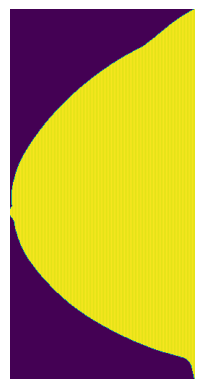

feature {'index': 1, 'radius': 6649.175212493204, 'texture': 57.409594588883806, 'perimeter': 41778.0, 'area': 42036, 'smoothness': 41521.58349985727, 'compactness': 41521.58349985727, 'concavity': 43172, 'concave_points': -84698, 'symmetry': 41.423828125, 'fractal_dimension': 0.6192270164418667, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/2545700.png'}
feature_array [{'index': 0, 'radius': 6688.32732849381, 'texture': 57.34799414263849, 'perimeter': 42024.0, 'area': 42280, 'smoothness': 41769.55004730369, 'compactness': 41769.55004730369, 'concavity': 43506, 'concave_points': -85274, 'symmetry': 41.5517578125, 'fractal_dimension': 0.6191573566983136, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/2545700.png'}, {'index': 1, 'radius': 6649.175212493204, 'texture': 57.409594588883806, 'perimeter': 41778.0, 'area'

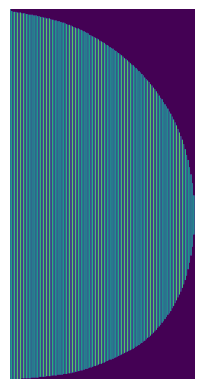

feature {'index': 1, 'radius': 4144.076408226771, 'texture': 36.97927025007075, 'perimeter': 26038.0, 'area': 26166, 'smoothness': 25910.62615608041, 'compactness': 25910.62615608041, 'concavity': 77827, 'concave_points': -103481, 'symmetry': 53.185546875, 'fractal_dimension': 0.6247098556450231, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/7057000.png'}
feature {'index': 2, 'radius': 4105.401757055441, 'texture': 36.96062114593802, 'perimeter': 25795.0, 'area': 25923, 'smoothness': 25667.63202561432, 'compactness': 25667.63202561432, 'concavity': 77140, 'concave_points': -102554, 'symmetry': 52.34765625, 'fractal_dimension': 0.6248272380021077, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/7057000.png'}
feature_array [{'index': 0, 'radius': 8212.076753655616, 'texture': 37.164466599184394, 'perimeter': 51598.0,

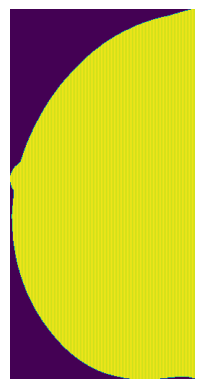

feature {'index': 1, 'radius': 8164.330270728047, 'texture': 59.531357020416735, 'perimeter': 51298.0, 'area': 51558, 'smoothness': 51039.31114473021, 'compactness': 51039.31114473021, 'concavity': 51831, 'concave_points': -102877, 'symmetry': 53.7197265625, 'fractal_dimension': 0.6169195337329083, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/6630578.png'}
feature_array [{'index': 0, 'radius': 8206.824640533583, 'texture': 59.19201743388638, 'perimeter': 51565.0, 'area': 51823, 'smoothness': 51308.284448989834, 'compactness': 51308.284448989834, 'concavity': 52037, 'concave_points': -103348, 'symmetry': 53.955078125, 'fractal_dimension': 0.6168606129184977, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/6630578.png'}, {'index': 1, 'radius': 8164.330270728047, 'texture': 59.531357020416735, 'perimeter': 51298.0, '

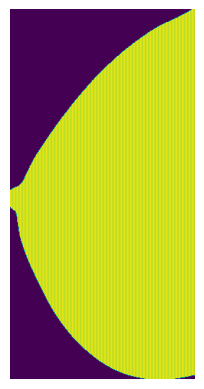

feature {'index': 1, 'radius': 7225.952726258232, 'texture': 50.230893032544614, 'perimeter': 45402.0, 'area': 45658, 'smoothness': 45147.435367295984, 'compactness': 45147.435367295984, 'concavity': 45994, 'concave_points': -91140, 'symmetry': 49.7880859375, 'fractal_dimension': 0.6182772198361518, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/3021820.png'}
feature_array [{'index': 0, 'radius': 7264.468222486471, 'texture': 50.13186209795712, 'perimeter': 45644.0, 'area': 45900, 'smoothness': 45389.42779956427, 'compactness': 45389.42779956427, 'concavity': 46180, 'concave_points': -91568, 'symmetry': 50.01953125, 'fractal_dimension': 0.6182172283474954, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/3021820.png'}, {'index': 1, 'radius': 7225.952726258232, 'texture': 50.230893032544614, 'perimeter': 45402.0, 'are

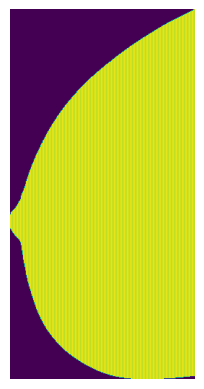

feature {'index': 1, 'radius': 7545.058387157483, 'texture': 68.4170921467087, 'perimeter': 47407.0, 'area': 47663, 'smoothness': 47152.3749868871, 'compactness': 47152.3749868871, 'concavity': 48078, 'concave_points': -95229, 'symmetry': 53.021484375, 'fractal_dimension': 0.6177914751470786, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/3504026.png'}
feature_array [{'index': 0, 'radius': 7585.006277873548, 'texture': 68.12700894206806, 'perimeter': 47658.0, 'area': 47914, 'smoothness': 47403.36778394624, 'compactness': 47403.36778394624, 'concavity': 48317, 'concave_points': -95719, 'symmetry': 53.244140625, 'fractal_dimension': 0.6177324177486673, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/3504026.png'}, {'index': 1, 'radius': 7545.058387157483, 'texture': 68.4170921467087, 'perimeter': 47407.0, 'area': 4766

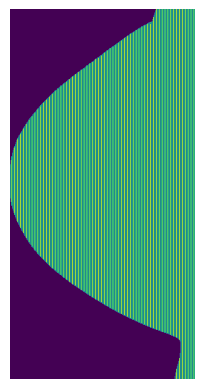

feature {'index': 1, 'radius': 6743.872403632881, 'texture': 40.04779946209683, 'perimeter': 42373.0, 'area': 42638, 'smoothness': 42109.647005019, 'compactness': 42109.647005019, 'concavity': 46910, 'concave_points': -89036, 'symmetry': 46.1630859375, 'fractal_dimension': 0.6190724260423184, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/6087671.png'}
feature {'index': 2, 'radius': 3372.3340891741705, 'texture': 39.922245817162064, 'perimeter': 21189.0, 'area': 21322, 'smoothness': 21056.829612606696, 'compactness': 21056.829612606696, 'concavity': 67599, 'concave_points': -88409, 'symmetry': 45.869140625, 'fractal_dimension': 0.6273577445614117, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/6087671.png'}
feature_array [{'index': 0, 'radius': 3334.932677547575, 'texture': 39.7766671173484, 'perimeter': 20954.0, '

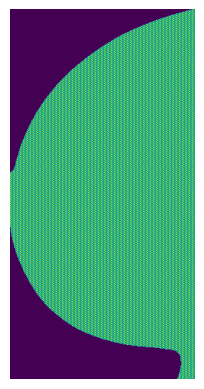

feature_array [{'index': 0, 'radius': 7641.010243984869, 'texture': 35.23532421168616, 'perimeter': 48009.883297014436, 'area': 63722, 'smoothness': 36171.94837250785, 'compactness': 36171.94837250785, 'concavity': 34271, 'concave_points': -97481, 'symmetry': 47.9287109375, 'fractal_dimension': 0.630536454621175, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/2718523.png'}]
feature_array []
feature {'index': 0, 'radius': 7250.94005232366, 'texture': 42.68328116739851, 'perimeter': 45559.0, 'area': 45816, 'smoothness': 45303.44161428322, 'compactness': 45303.44161428322, 'concavity': 46385, 'concave_points': -91689, 'symmetry': 59.6572265625, 'fractal_dimension': 0.618239273211857, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/5002218.png'}
labeled_image [[368  10 368 ...   0   0   0]
 [368  10 368 ...   0   0   0]

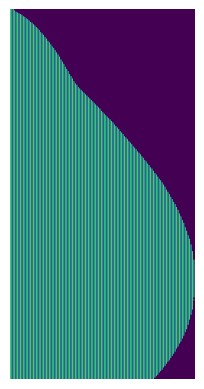

feature {'index': 1, 'radius': 7287.863999120979, 'texture': 42.832915617319046, 'perimeter': 45791.0, 'area': 46048, 'smoothness': 45535.434351111886, 'compactness': 45535.434351111886, 'concavity': 46577, 'concave_points': -92113, 'symmetry': 59.8671875, 'fractal_dimension': 0.61818198650641, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/5002218.png'}
feature_array [{'index': 0, 'radius': 7250.94005232366, 'texture': 42.68328116739851, 'perimeter': 45559.0, 'area': 45816, 'smoothness': 45303.44161428322, 'compactness': 45303.44161428322, 'concavity': 46385, 'concave_points': -91689, 'symmetry': 59.6572265625, 'fractal_dimension': 0.618239273211857, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/5002218.png'}, {'index': 1, 'radius': 7287.863999120979, 'texture': 42.832915617319046, 'perimeter': 45791.0, 'area': 4

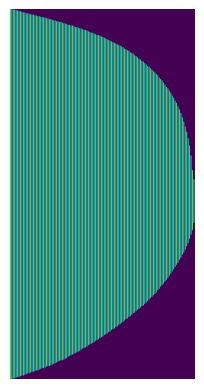

feature {'index': 1, 'radius': 7823.420382625208, 'texture': 65.18247644863766, 'perimeter': 49156.0, 'area': 49412, 'smoothness': 48901.326317493724, 'compactness': 48901.326317493724, 'concavity': 49370, 'concave_points': -98270, 'symmetry': 48.4072265625, 'fractal_dimension': 0.6173875937939035, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/7336492.png'}
feature_array [{'index': 0, 'radius': 7787.292210543347, 'texture': 65.47976298858248, 'perimeter': 48929.0, 'area': 49185, 'smoothness': 48674.332438751655, 'compactness': 48674.332438751655, 'concavity': 49160, 'concave_points': -97833, 'symmetry': 48.2001953125, 'fractal_dimension': 0.6174390252840195, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/7336492.png'}, {'index': 1, 'radius': 7823.420382625208, 'texture': 65.18247644863766, 'perimeter': 49156.0, 'a

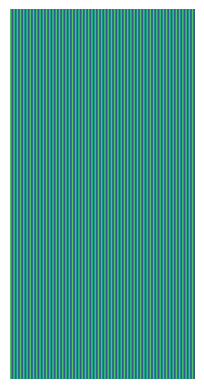

feature {'index': 1, 'radius': 10389.634685038927, 'texture': 76.02724576004076, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'compactness': 65025.0, 'concavity': 65024, 'concave_points': -130048, 'symmetry': 61.001953125, 'fractal_dimension': 0.6143260559750294, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/4703157.png'}
feature_array [{'index': 0, 'radius': 10389.634685038927, 'texture': 75.86732752423215, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'compactness': 65025.0, 'concavity': 65024, 'concave_points': -130048, 'symmetry': 61.052734375, 'fractal_dimension': 0.6143260559750294, 'label': 0, 'path': '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train/train_r_cc_false/4703157.png'}, {'index': 1, 'radius': 10389.634685038927, 'texture': 76.02724576004076, 'perimeter': 65280.0, 'area': 65536, 'smoothness': 65025.0, 'comp

In [ ]:
import sys
import os
import cv2
import csv
from skimage import io, color

from google.colab import drive
drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/segmentation.py')

# from segmentation import perform_segmentation, extract_features_from_segmentation


# Define the image size this is the file u sent removing those functions
IMG_SIZE = 5000

# Define the paths to the train, test, and val folders
# can you open the original file in vs code ok give me 2min
TRAIN_DIR = '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/train'
# TRAIN_DIR = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/fiveTwelve/train')
TEST_DIR = '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/test'
# TEST_DIR = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/fiveTwelve/test')
VAL_DIR = '/content/drive/MyDrive/Colab-Notebooks/Anomaly-Detection/Image_to_dataset/fiveTwelveSmall/val'
# VAL_DIR = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/fiveTwelve/val')


# Define the labels for the two classes (normal and abnormal)
CATEGORIES = ['false', 'true']

# Function to read and preprocess images
def read_and_preprocess_image(filepath):
    # Read the image file
    # img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(filepath)
    # Resize the image to the desired size
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Flatten the image to a 1D array
    img = img.flatten()
    return img

# Function to load images and labels from a directory
def load_data_from_folder(folder):
    # Initialize the image and label lists
    images = []
    labels = []
    features = []
    folds = os.listdir(folder)
    # Loop over the categories
    for category in folds:
        # Define the path to the category folder
        path = os.path.join(folder, category)
        # Loop over the image files in the category folder
        for filename in os.listdir(path):
            # Define the path to the image file
            filepath = os.path.join(path, filename)
            # Read and preprocess the image
            img = read_and_preprocess_image(filepath)

            # Load the grayscale image
            # Append the image and label to the lists
            label = 1
            if "false" in category:
                label = 0
            labeled_image = perform_segmentation(filepath)

            sample_img = io.imread(filepath)
            img_gray = sample_img

            # Only convert image to grayscale if RGB
            if sample_img.shape[-1] == 3:
              img_gray = color.rgb2gray(sample_img)

            feature_array = extract_features_from_segmentation(labeled_image, img_gray, label, filepath)
            print("feature_array", feature_array)
            feature = [item for sublist in feature_array for item in sublist]
            images.append(img)
            labels.append(label)
            features.append(feature)
    print("features", len(features))
    return images, labels, features
    print(images)
# Load the train, test, and val data
train_images, train_labels, train_feature = load_data_from_folder(TRAIN_DIR)
test_images, test_labels, test_feature = load_data_from_folder(TEST_DIR)
val_images, val_labels, val_feature = load_data_from_folder(VAL_DIR)

# print("feature",train_feature)

# best_feature = max(train_feature, key=lambda x: x['area'])
# print("best_feature", best_feature)

data = train_feature
# print("data", data)
# Open a CSV file for writing
# with open('train_final_7.csv', 'w', newline='') as csv_file:
#     writer = csv.writer(csv_file)

#     # Write the header row
#     writer.writerow(data[0].keys())

#     # Write each row of data
#     for row in data:
#         writer.writerow(row.values())
# creating a csv flow will be different in colab so what should b done just print it here or pass it to pd file

with open('train_final1.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    print("data", data[0])
    # Write the header row
    writer.writerow(data[0].keys())

    # Write each row of data
    for row in data:
        writer.writerow(row.values())